# Método de los Elementos Finitos con Python

*Esta notebook fue creada originalmente como un blog post por [Raúl E. López Briega](https://relopezbriega.com.ar/) en [Matemáticas, análisis de datos y python](https://relopezbriega.github.io). El contenido esta bajo la licencia BSD.*

<img alt="Método de los Elementos Finitos con python" title="Método de los Elementos Finitos con python" src="https://relopezbriega.github.io/images/FEM.png
" >

## Introducción

Muchos fenómenos físicos en ciencia e [ingeniería](https://es.wikipedia.org/wiki/Ingenier%C3%ADa) pueden ser descritos en términos de [ecuaciones en derivadas parciales](https://relopezbriega.github.io/blog/2016/01/27/ecuaciones-en-derivadas-parciales-con-python/), y como describí en mi [artículo](https://relopezbriega.github.io/blog/2016/01/27/ecuaciones-en-derivadas-parciales-con-python/) dedicado a este tipo de ecuaciones, resolverlas a través del método analítico clásico puede ser algo bastante complicado y muchas veces imposible de realizar. El [Método de los Elementos Finitos](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos) o [MEF](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos), para abreviar; es un enfoque numérico por el cual las [ecuaciones en derivadas parciales](https://relopezbriega.github.io/blog/2016/01/27/ecuaciones-en-derivadas-parciales-con-python/) pueden ser resueltas en forma aproximada. El [MEF](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos) está pensado para ser utilizado con el enorme poder de cálculo de las computadoras modernas y permite resolver [ecuaciones diferenciales](https://relopezbriega.github.io//blog/2016/01/10/ecuaciones-diferenciales-con-python/) asociadas a un problema físico sobre geometrías complicadas. Este método se usa en el diseño y mejora de productos y aplicaciones industriales, así como en la simulación de sistemas físicos y biológicos complejos. La variedad de problemas a los que puede aplicarse ha crecido enormemente, utilizándose principalmente en áreas como [mecánica estructural](https://en.wikipedia.org/wiki/Structural_mechanics), [mecánica de fluidos](https://es.wikipedia.org/wiki/Mec%C3%A1nica_de_fluidos), problemas de [tensión mecánica](https://es.wikipedia.org/wiki/Tensi%C3%B3n_mec%C3%A1nica) y problemas de [transferencia de calor](https://es.wikipedia.org/wiki/Transferencia_de_calor).

***Nota:*** Este artículo corresponde a la cuarta entrega de mi serie de artículos sobre [Cálculo](https://relopezbriega.github.io/category/calculo.html) con [Python](https://www.python.org/); los anteriores fueron: [Introducción al Cálculo](https://relopezbriega.github.io/blog/2015/12/02/introduccion-al-calculo-con-python/),  [Ecuaciones Diferenciales con Python](https://relopezbriega.github.io/blog/2016/01/10/ecuaciones-diferenciales-con-python/) y [Ecuaciones en derivadas parciales con Python](https://relopezbriega.github.io/blog/2016/01/27/ecuaciones-en-derivadas-parciales-con-python/), los cuales es recomendable haber leído previamente.

## ¿En qué consiste el Método de los Elementos Finitos?

La idea general detrás del [Método de los Elementos Finitos](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos) es la división de un *continuo* en un
conjunto de pequeños *elementos* interconectados por una serie de puntos llamados *nodos*. 
Las ecuaciones que rigen el comportamiento del continuo regirán también el del elemento.
De esta forma se consigue pasar de un sistema continuo (infinitos grados de libertad), que
es regido por una [ecuación diferencial](https://relopezbriega.github.io//blog/2016/01/10/ecuaciones-diferenciales-con-python/) o un sistema de [ecuaciones diferenciales](https://relopezbriega.github.io//blog/2016/01/10/ecuaciones-diferenciales-con-python/), a un
sistema con un número de grados de libertad finito cuyo comportamiento se modela por un
sistema de ecuaciones, lineales o no. 

<img alt="Método de los Elementos Finitos con python" title="Método de los Elementos Finitos con python" src="https://relopezbriega.github.io/images/FEM.png
" >

Por ejemplo, en la imagen que vemos arriba, podemos ver que en primer lugar tenemos una placa con un hueco en el centro, supongamos que queremos determinar su distribución de temperatura. Para realizar esto, deberíamos resolver la [ecuación del calor](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_del_calor) para cada punto en la placa. El enfoque que utiliza el [Método de los Elementos Finitos](https://es.wikipedia.org/wiki/M%C3%A9todo_de_los_elementos_finitos) es el de dividir al objeto en *elementos finitos* conectados entre sí por *nodos*; como se muestra en la tercera y cuarta imagen. Este nuevo objeto, constituido por los *elementos finitos* (los triángulos de la segunda imagen) se llama [malla](https://es.wikipedia.org/wiki/Malla_poligonal) y es una representación aproximada del objeto original. De esta forma, pasamos de un problema continuo (infinito puntos) a un problema discreto (número de *nodos* de los *elementos finitos*). Para aproximarnos lo más posible al objeto original, generalmente se necesitan un número elevado de *nodos*, por lo que las computadoras son esenciales para resolver el problema.

## Pasos para utilizar el Método de los Elementos Finitos

Motivation
We use the finite element method for several reasons. Analytical models are limited in their application. This is the case if we have:

• complex geometries

• complex loadings (point of force application,…)

• material laws, for instance

The following five steps are essential to know in order to understand what the approach of the FEM is:

First step (Preprocessing):
• Create geometry
• Define material properties
• Choose initial and boundary conditions
• Define (if necessary) side conditions like contact definitions
• Discretization of the geometry -> MESH

Second step:
Element formulation -> development of equations for elements
Set up the partial differential equation in its weak form

Third step:
Assembly: Set up global problem -> obtaining equations for the entire system from the equations for one element

Fourth step:
Solving the equations (solve system of linear equations)

Fifth step:
Postprocessing: determining quantities of interest, such as stresses and strains and obtaining visualizations of the response


## Formulación fuerte y débil del problema

https://es.wikipedia.org/wiki/Formulaci%C3%B3n_d%C3%A9bil_de_una_ecuaci%C3%B3n_diferencial

## FEniCS

https://fenicsproject.org/tutorial/

### Ejemplo en Python



In [1]:
# <!-- collapse=True -->
# Importando las librerías que vamos a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import dolfin
import mshr

# graficos incrustados
%matplotlib inline

# parametros para FEniCS
dolfin.parameters["reorder_dofs_serial"] = False
dolfin.parameters["allow_extrapolation"] = True

In [2]:
# Generando la malla
r_outer = 1
r_inner = 0.25
r_middle = 0.1
x0, y0 = 0.4, 0.4

domain = mshr.Circle(dolfin.Point(.0, .0), r_outer) - mshr.Circle(dolfin.Point(.0, .0), r_inner) \
- mshr.Circle(dolfin.Point( x0,  y0), r_middle) \
- mshr.Circle(dolfin.Point( x0, -y0), r_middle) \
- mshr.Circle(dolfin.Point(-x0,  y0), r_middle) \
- mshr.Circle(dolfin.Point(-x0, -y0), r_middle) \

mesh = mshr.generate_mesh(domain, 10)
mesh

In [8]:
# Definimos el espacio funcional
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

In [9]:
# Formulación debil de la EDP
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx
f = dolfin.Constant(0.0)
L = f * v * dolfin.dx

In [11]:
# Defino condiciones de frontera
def u0_inner_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(np.sqrt(x**2 + y**2) - r_inner)< 5e-2
def u0_middle_boundary(x, on_boundary):
    x, y = x[0], x[1]
    if on_boundary:
        for _x0 in [-x0, x0]:
            for _y0 in [-y0, y0]:
                if abs(np.sqrt((x-_x0)**2 + (y-_y0)**2) - r_middle) < 5e-2:
                    return True
    return False

In [13]:
# Definiendo condiciones de frontera de Dirichlet
bc_inner = dolfin.DirichletBC(V, dolfin.Constant(10), u0_inner_boundary)
bc_middle = dolfin.DirichletBC(V, dolfin.Constant(0), u0_middle_boundary)
bcs = [bc_inner, bc_middle]

In [15]:
# Resolviendo la EDP
u_sol = dolfin.Function(V)
dolfin.solve(a == L, u_sol, bcs)

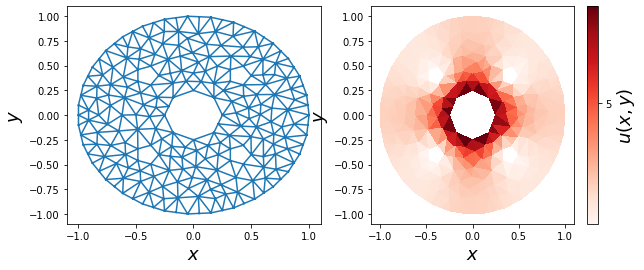

In [16]:
# Graficando la solución
coordinates = mesh.coordinates()
triangles = mesh.cells()
triangulation = mpl.tri.Triangulation(coordinates[:, 0], coordinates[:, 1], triangles)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
c = ax2.tripcolor(triangulation, np.array(u_sol.vector()), cmap=mpl.cm.get_cmap("Reds"))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 5, 10, 15])

Saludos!

*Este post fue escrito utilizando Jupyter notebook. Pueden descargar este [notebook](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/pyFEM.ipynb) o ver su version estática en [nbviewer](https://nbviewer.ipython.org/github/relopezbriega/relopezbriega.github.io/blob/master/downloads/pyFEM.ipynb).*